In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import lightgbm as lgb

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\asus\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [3]:
data = pd.read_csv('mtsamples.csv')
print(data.shape)
data.head()

(4999, 6)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [4]:
data = data[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)

In [5]:
data.iloc[4]['transcription']

'1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%.  There is near-cavity obliteration seen.  There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function.  There is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by Doppler examination.,2.  The left atrium appears mildly dilated.,3.  The right atrium and right ventricle appear normal.,4.  The aortic root appears normal.,5.  The aortic valve appears calcified with mild aortic valve stenosis, calculated aortic valve area is 1.3 cm square with a maximum instantaneous gradient of 34 and a mean gradient of 19 mm.,6.  There is mitral annular calcification extending to leaflets and supportive structures with thickening of mitral valve leaflets with mi

In [6]:
data['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Dentistry                          27
 Cosmetic / Plastic Surge

In [7]:
tokenizer = RegexpTokenizer(r'\w+')
data["tokens"] = data["transcription"].apply(tokenizer.tokenize)

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" %(len(all_words), len(VOCAB)))
print("Max sentence length is %s" %max(sentence_lengths))

2420937 words total, with a vocabulary size of 28581
Max sentence length is 3114


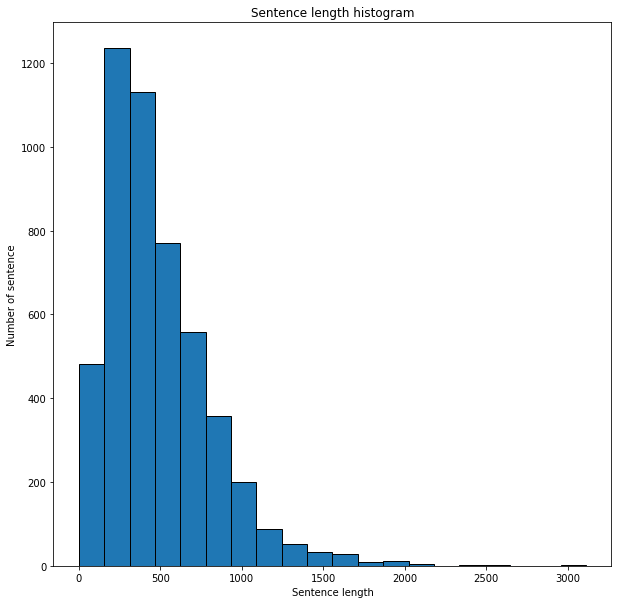

In [8]:
fig = plt.figure(figsize=(10, 10))
plt.title('Sentence length histogram')
plt.xlabel('Sentence length')
plt.ylabel('Number of sentence')
plt.hist(sentence_lengths, edgecolor = 'black', bins = 20)
plt.show()

In [9]:
print(f"Median sentence length {np.median(sentence_lengths)}")
print(f"Mean sentence lengt {round(np.mean(sentence_lengths), 2)}")

Median sentence length 421.5
Mean sentence lengt 487.5


In [10]:
def basic_preprocessing(df):
    
    df_temp = df.copy(deep = True)
    
    df_temp = df_temp.rename(index = str, columns = {'transcription': 'text'})
    
    df_temp.loc[:, 'text'] = [text_prepare(x) for x in df_temp['text'].values]
    
    le = LabelEncoder()
    le.fit(df_temp['medical_specialty'])
    df_temp.loc[:, 'class_label'] = le.transform(df_temp['medical_specialty'])
    
    tokenizer = RegexpTokenizer(r'\w+')

    df_temp["tokens"] = df_temp["text"].apply(tokenizer.tokenize)
    
    return df_temp

def text_prepare(text):

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub('', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text

def get_metrics(y_test, y_predicted):  

    precision = precision_score(y_test, y_predicted, average='weighted')             

    recall = recall_score(y_test, y_predicted, average='weighted')
    
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [11]:
def BOW(data):
    
    df_temp = data.copy(deep = True)
    df_temp = basic_preprocessing(df_temp)

    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(df_temp['text'])

    list_corpus = df_temp["text"].tolist()
    list_labels = df_temp["class_label"].tolist()
    
    X = count_vectorizer.transform(list_corpus)
    
    return X, list_labels

In [12]:
def tfidf(data, ngrams = 1):
    df_temp = data.copy(deep = True)
    df_temp = basic_preprocessing(df_temp)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, ngrams))
    tfidf_vectorizer.fit(df_temp['text'])
    
    list_corpus = df_temp["text"].tolist()
    list_labels = df_temp["class_label"].tolist()
    
    X = tfidf_vectorizer.transform(list_corpus)
    
    return X, list_labels

In [14]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [15]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [16]:
def w2v(data):
    
    df_temp = data.copy(deep = True)    
    df_temp = basic_preprocessing(df_temp)
    
    embeddings = get_word2vec_embeddings(word2vec, df_temp)
    list_labels = df_temp["class_label"].tolist()
    
    return embeddings, list_labels

In [17]:
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state = 40)
clf = LogisticRegressionCV(cv = folds, solver = 'saga', 
                           multi_class = 'multinomial', n_jobs = -1, random_state = 40)
df_res = pd.DataFrame(columns = ['Preprocessing', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

X, y = BOW(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'Bag of words',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

X, y = tfidf(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'TF-IDF 1-gram',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

X, y = tfidf(data, ngrams=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'TF-IDF 2-gram',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

X, y = w2v(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'Word2vec',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

In [18]:
df_res

,Preprocessing,Precision,Recall,F1-score,Accuracy
0,Bag of words,0.256824,0.340040,0.258735,0.340040
1,TF-IDF 1-gram,0.204859,0.343058,0.223699,0.343058
2,TF-IDF 2-gram,0.144673,0.321932,0.179239,0.321932
3,Word2vec,0.318220,0.378270,0.319280,0.378270


In [22]:
counts = data['medical_specialty'].value_counts()
data_100 = data[data['medical_specialty'].isin(counts[counts > 100].index)]

In [23]:
data_100['lables'] = LabelEncoder().fit_transform(data_100['medical_specialty'])

In [24]:
data_100['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
Name: medical_specialty, dtype: int64

In [35]:
def training_naive(X_train_naive, X_test_naive, y_train_naive, y_test_naive, preproc):
    
    clf = MultinomialNB()
    clf.fit(X_train_naive, y_train_naive)

    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_naive)
    
    f1 = f1_score(y_pred, y_test_naive, average = 'weighted')
    pres = precision_score(y_pred, y_test_naive, average = 'weighted')
    rec = recall_score(y_pred, y_test_naive, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_naive)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'Naive Bayes', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

In [38]:
def training_logreg(X_train_log, X_test_log, y_train_log, y_test_log, preproc):
    
    folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 40)
    
    clf = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
    
    clf.fit(X_train_log, y_train_log)

    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_log)
    
    f1 = f1_score(y_pred, y_test_log, average = 'weighted')
    pres = precision_score(y_pred, y_test_log, average = 'weighted')
    rec = recall_score(y_pred, y_test_log, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_log)
    
    res = res.append({'Preprocessing': preproc, 'Model': f'Logistic Regression', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

In [31]:
def training_lgbm(X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm, preproc,
                 n = 120, depth = 4, child = 2, bag = 0.9, feature = 0.9, l1 = 1, l = 0.01, w2v = False):
    
    if w2v:
        d_train = lgb.Dataset(X_train_lgbm, label=y_train_lgbm)
    else:
        d_train = lgb.Dataset(X_train_lgbm.astype(np.float32), label=y_train_lgbm)

    early_stop = 500
    verbose_eval = False
    num_rounds = n

    params = {
        'objective': 'multiclass',
        'num_class': len(set(y_train_lgbm)),
        'boosting': 'gbdt', 
        'metric': 'multi_logloss',
        'max_depth': depth, 
        'max_bin': 22, 
        'bagging_fraction': bag, 
        'feature_fraction': feature, 
        'min_child_samples': child, 
        'min_child_weight': 1, 
        'learning_rate': l,
        'verbosity': -1, 
        'data_random_seed': 17,
        'lambda_l1': l1}

    model = lgb.train(params, train_set = d_train, num_boost_round = num_rounds)

    y_pred_proba = model.predict(X_test_lgbm.astype(np.float32), num_iteration=model.best_iteration)
    y_pred = [np.argmax(x) for x in y_pred_proba]
    
    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
        
    f1 = f1_score(y_pred, y_test_lgbm, average = 'weighted')
    pres = precision_score(y_pred, y_test_lgbm, average = 'weighted')
    rec = recall_score(y_pred, y_test_lgbm, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_lgbm)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'LightGBM', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

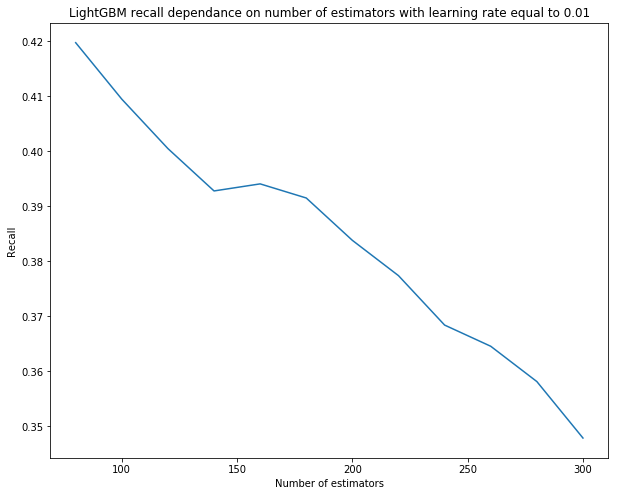

In [32]:
X, y = BOW(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
ns = range(80, 301, 20)
recalls = []
for n in ns:
    recalls.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count', n = n, l = 0.01)['Recall'].values[0])
fig = plt.figure(figsize = (10, 8))
plt.plot(ns, recalls, label = 'Recall')
plt.xlabel('Number of estimators')
plt.ylabel('Recall')
plt.title('LightGBM recall dependance on number of estimators with learning rate equal to 0.01')
plt.show()

In [33]:
depths = range(2, 7, 2)
childs = range(2, 7, 2)
recalls = []
for depth in depths:
    for child in childs:
        recalls.append([training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-gram', 
                                     n = 120, l = 0.01, depth = depth, child = child)['Recall'].values[0], depth, child])
recalls.sort(reverse = True)
recalls[:3]

[[0.46469833119383824, 2, 6],
 [0.4634146341463415, 2, 4],
 [0.4634146341463415, 2, 2]]

In [39]:
full_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

X, y = BOW(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

X, y = tfidf(data_100, ngrams = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

X, y = tfidf(data_100, ngrams = 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

X, y = w2v(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

full_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.455078,0.388960,0.413204,0.388960
1,Count Vectorize,Logistic Regression,0.632613,0.440308,0.507545,0.440308
2,Count Vectorize,LightGBM,0.554771,0.400513,0.456310,0.400513
3,TF-IDF 1-grams,Naive Bayes,0.954386,0.426187,0.587129,0.426187
4,TF-IDF 1-grams,Logistic Regression,0.761526,0.435173,0.543913,0.435173
5,TF-IDF 1-grams,LightGBM,0.500559,0.374840,0.421892,0.374840
6,TF-IDF 2-grams,Naive Bayes,0.922098,0.406932,0.560075,0.406932
7,TF-IDF 2-grams,Logistic Regression,0.855491,0.418485,0.554689,0.418485
8,TF-IDF 2-grams,LightGBM,0.501391,0.368421,0.417966,0.368421
9,Word2vec,Logistic Regression,0.602675,0.472401,0.516603,0.472401


In [40]:
X, y = w2v(data_100)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=40)
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 40)
clf_w2v = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
clf_w2v.fit(X_train_log, y_train_log)
y_pred = clf_w2v.predict(X_test_log)

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10, rotation = 90)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=12)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

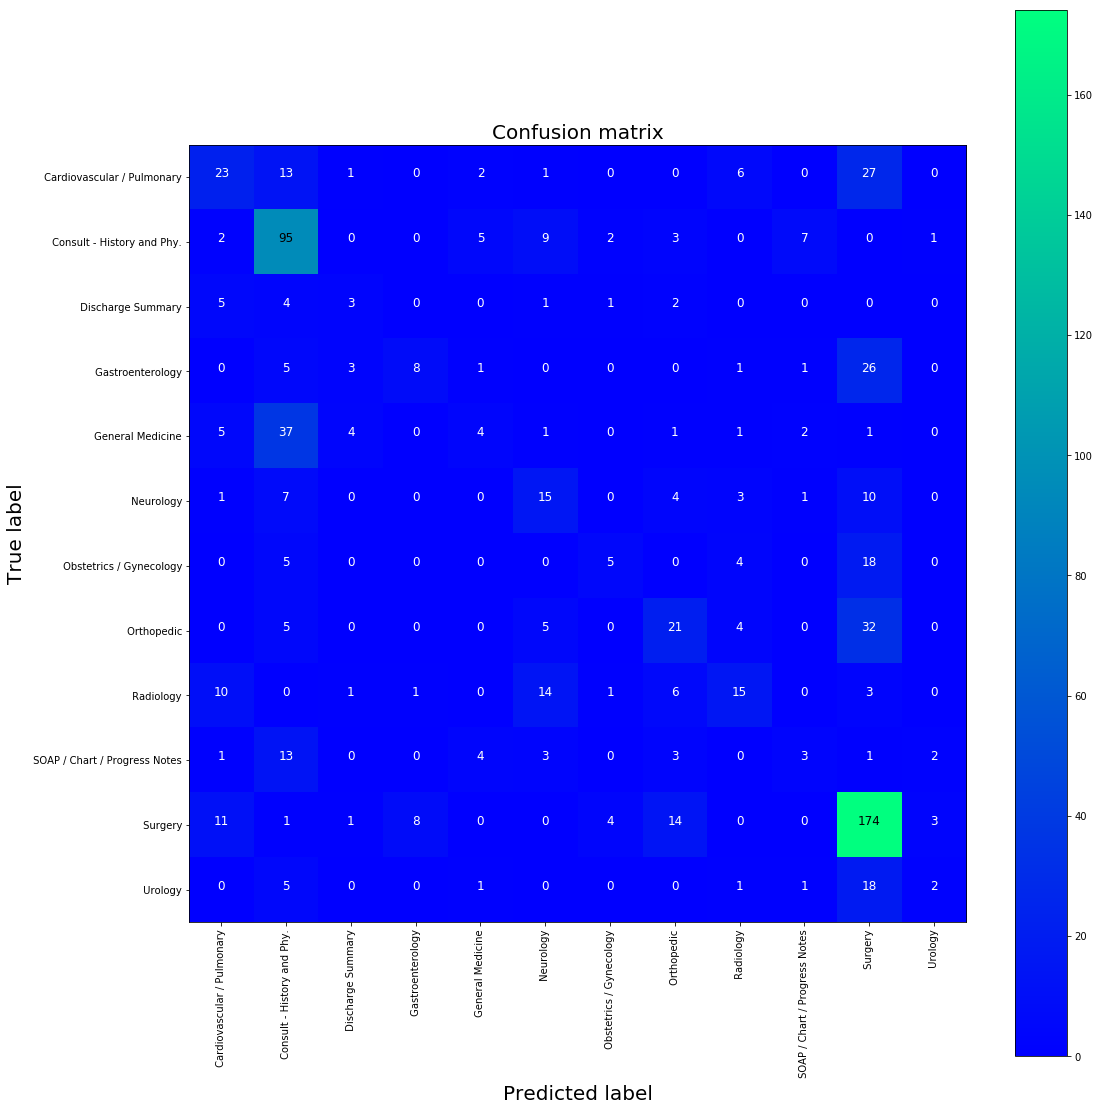

In [42]:
classes = [' Cardiovascular / Pulmonary', ' Consult - History and Phy.', ' Discharge Summary',
           ' Gastroenterology', ' General Medicine', ' Neurology', ' Obstetrics / Gynecology',
           ' Orthopedic', ' Radiology', ' SOAP / Chart / Progress Notes', ' Surgery', ' Urology']
cm = confusion_matrix(y_test_log, y_pred)
fig = plt.figure(figsize=(16, 16))
plot = plot_confusion_matrix(cm, classes=classes, normalize=False, 
                             title='Confusion matrix')
plt.show()

In [43]:
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(CountVectorizer(), clf)

random.seed(40)

data_100_prep = basic_preprocessing(data_100)
list_corpus = data_100_prep["text"].tolist()
list_labels = data_100_prep["class_label"].tolist()

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)

    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]
                
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: ' Cardiovascular / Pulmonary',
    1: ' Consult - History and Phy.',
    2: ' Discharge Summary',
    3: ' Gastroenterology',
    4: ' General Medicine',
    5: ' Neurology',
    6: ' Obstetrics / Gynecology',
    7: ' Orthopedic',
    8: ' Radiology',
    9: ' SOAP / Chart / Progress Notes',
    10: ' Surgery',
    11: ' Urology'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

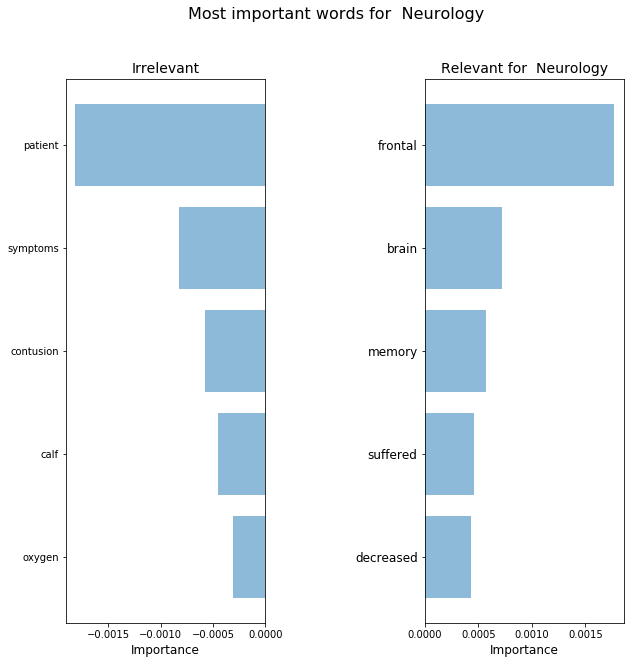

In [44]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=14)
    plt.yticks(y_pos, bottom_words, fontsize=10)
    plt.suptitle('Key words', fontsize=12)
    plt.xlabel('Importance', fontsize=12)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title("Relevant for " + name, fontsize=14)
    plt.yticks(y_pos, top_words, fontsize=12)
    plt.suptitle(f"Most important words for {name}", fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

test_label = ' Neurology'
top_words = sorted_contributions[test_label]['supporters'][:5].index.tolist()
top_scores = sorted_contributions[test_label]['supporters'][:5].tolist()
bottom_words = sorted_contributions[test_label]['detractors'][:5].index.tolist()
bottom_scores = sorted_contributions[test_label]['detractors'][:5].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, test_label)

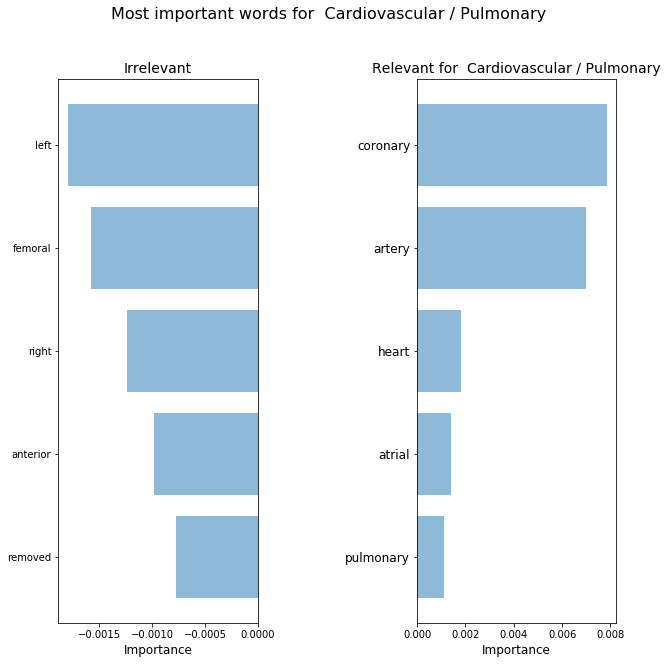

In [45]:
test_label = ' Cardiovascular / Pulmonary'
top_words = sorted_contributions[test_label]['supporters'][:5].index.tolist()
top_scores = sorted_contributions[test_label]['supporters'][:5].tolist()
bottom_words = sorted_contributions[test_label]['detractors'][:5].index.tolist()
bottom_scores = sorted_contributions[test_label]['detractors'][:5].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, test_label)

In [46]:
naive_under_sample = RandomUnderSampler(sampling_strategy = 'majority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = naive_under_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 3894
Initial set target classes 12
Modified set observations 2914
Modified set target classes 12


In [47]:
naive_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

naive_under_sample = RandomUnderSampler(sampling_strategy = 'majority')

X, y = BOW(data_100)
X, y = naive_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
naive_result = naive_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
naive_result = naive_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
naive_result = naive_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

X, y = tfidf(data_100, ngrams = 1)
X, y = naive_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
naive_result = naive_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
naive_result = naive_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
naive_result = naive_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

X, y = w2v(data_100)
X, y = naive_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
naive_result = naive_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [48]:
naive_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.529403,0.435678,0.463757,0.435678
1,Count Vectorize,Logistic Regression,0.595358,0.492281,0.520655,0.492281
2,Count Vectorize,LightGBM,0.502744,0.464837,0.475266,0.464837
3,TF-IDF 1-grams,Naive Bayes,0.798967,0.413379,0.501406,0.413379
4,TF-IDF 1-grams,Logistic Regression,0.701031,0.488851,0.552688,0.488851
5,TF-IDF 1-grams,LightGBM,0.510618,0.457976,0.477298,0.457976
6,Word2vec,Logistic Regression,0.543398,0.492281,0.509549,0.492281


In [49]:
near_under_sample = NearMiss(sampling_strategy='majority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = near_under_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 3894
Initial set target classes 12
Modified set observations 2914
Modified set target classes 12


In [50]:
near_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

near_under_sample = NearMiss(sampling_strategy='majority')

X, y = BOW(data_100)
X, y = near_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
near_result = near_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
near_result = near_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
near_result = near_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

X, y = tfidf(data_100, ngrams = 1)
X, y = near_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
near_result = near_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
near_result = near_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
near_result = near_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

X, y = w2v(data_100)
X, y = near_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
near_result = near_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [51]:
near_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.536286,0.437393,0.471270,0.437393
1,Count Vectorize,Logistic Regression,0.593574,0.488851,0.521999,0.488851
2,Count Vectorize,LightGBM,0.512047,0.476844,0.486985,0.476844
3,TF-IDF 1-grams,Naive Bayes,0.796013,0.413379,0.499468,0.413379
4,TF-IDF 1-grams,Logistic Regression,0.698165,0.488851,0.551167,0.488851
5,TF-IDF 1-grams,LightGBM,0.514414,0.457976,0.478532,0.457976
6,Word2vec,Logistic Regression,0.543958,0.500858,0.514244,0.500858


In [52]:
smote_over_sample = SMOTE(sampling_strategy='minority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = smote_over_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 3894
Initial set target classes 12
Modified set observations 4874
Modified set target classes 12


In [53]:
smote_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

smote_over_sample = SMOTE(sampling_strategy='minority')

In [54]:
X, y = BOW(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
smote_result = smote_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
smote_result = smote_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

In [55]:
X, y = tfidf(data_100, ngrams = 1)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
smote_result = smote_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
smote_result = smote_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

In [56]:
X, y = w2v(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [57]:
smote_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.596192,0.513846,0.540070,0.513846
1,Count Vectorize,Logistic Regression,0.731784,0.547692,0.613728,0.547692
2,Count Vectorize,LightGBM,0.653170,0.509744,0.565395,0.509744
3,TF-IDF 1-grams,Naive Bayes,0.937583,0.465641,0.609816,0.465641
4,TF-IDF 1-grams,Logistic Regression,0.838644,0.556923,0.654445,0.556923
5,TF-IDF 1-grams,LightGBM,0.651105,0.525128,0.571761,0.525128
6,Word2vec,Logistic Regression,0.597260,0.537436,0.561222,0.537436


In [58]:
adasyn_over_sample = ADASYN(sampling_strategy='minority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = adasyn_over_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 3894
Initial set target classes 12
Modified set observations 4869
Modified set target classes 12


In [59]:
adasyn_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

adasyn_over_sample = ADASYN(sampling_strategy='minority')

X, y = BOW(data_100)
X, y = adasyn_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
adasyn_result = adasyn_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
adasyn_result = adasyn_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
adasyn_result = adasyn_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

X, y = tfidf(data_100, ngrams = 1)
X, y = adasyn_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
adasyn_result = adasyn_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
adasyn_result = adasyn_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
adasyn_result = adasyn_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

X, y = w2v(data_100)
X, y = adasyn_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
adasyn_result = adasyn_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [60]:
adasyn_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.582618,0.516427,0.539436,0.516427
1,Count Vectorize,Logistic Regression,0.720288,0.552361,0.613799,0.552361
2,Count Vectorize,LightGBM,0.653106,0.517454,0.569906,0.517454
3,TF-IDF 1-grams,Naive Bayes,0.939744,0.449795,0.598055,0.449795
4,TF-IDF 1-grams,Logistic Regression,0.807919,0.548156,0.637627,0.548156
5,TF-IDF 1-grams,LightGBM,0.635397,0.517418,0.560459,0.517418
6,Word2vec,Logistic Regression,0.695951,0.557495,0.609013,0.557495


In [61]:
X, y = w2v(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.2, random_state=40)
clf_w2v_smote = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
clf_w2v_smote.fit(X_train_smote, y_train_smote)
y_pred = clf_w2v_smote.predict(X_test_smote)

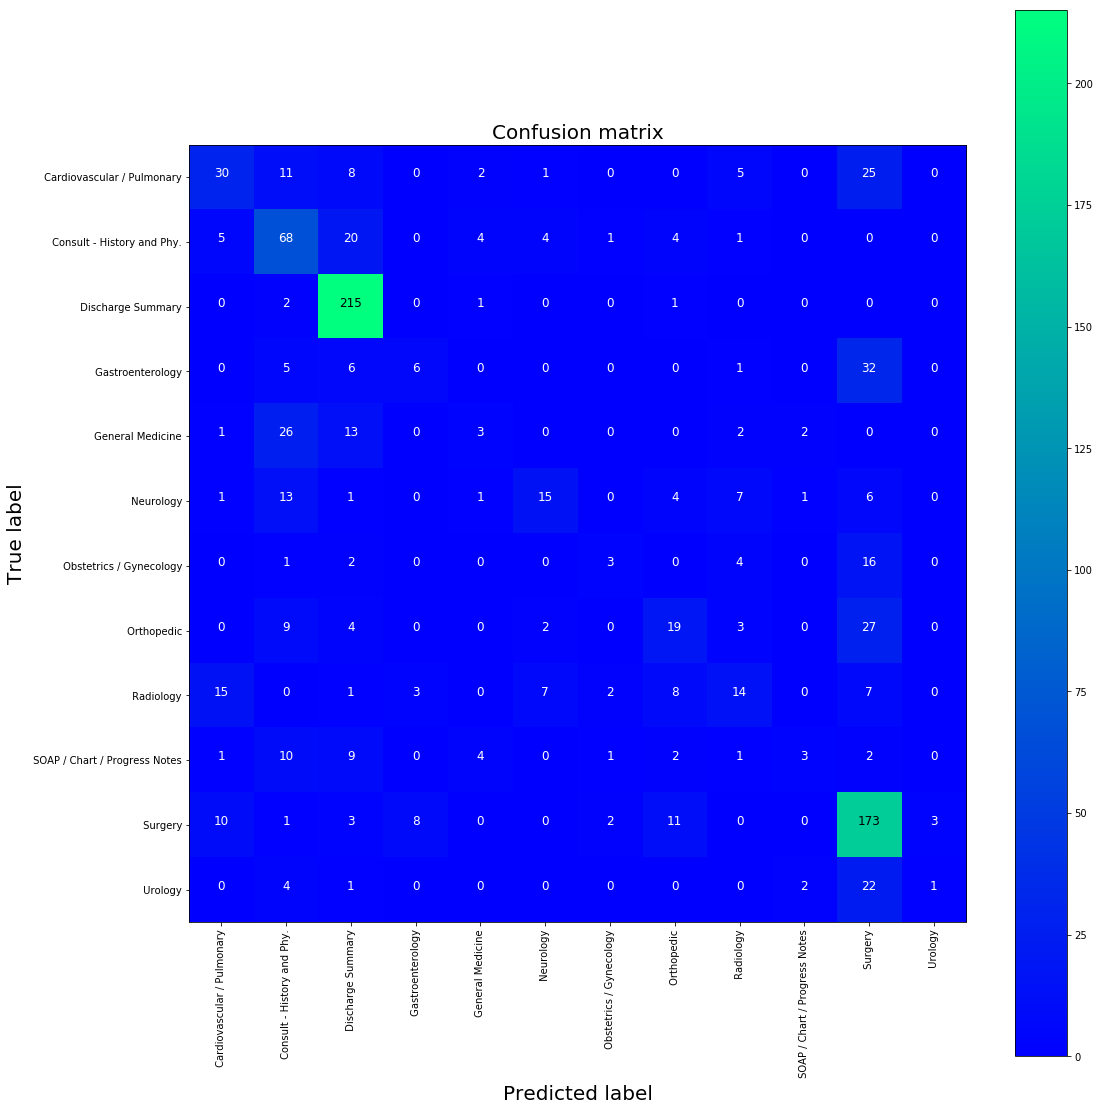

In [62]:
cm = confusion_matrix(y_test_smote, y_pred)
fig = plt.figure(figsize=(16, 16))
plot = plot_confusion_matrix(cm, classes=classes, normalize=False, 
                             title='Confusion matrix')
plt.show()

In [63]:
final_metrics = pd.DataFrame({'Labels': range(12),
                              'Recall': recall_score(y_pred, y_test_smote, average = None),
                             'Precision': precision_score(y_pred, y_test_smote, average = None),
                             'F1-score': f1_score(y_pred, y_test_smote, average = None)})
final_metrics['Labels'] = final_metrics['Labels'].replace(label_to_text)
final_metrics

,Labels,Recall,Precision,F1-score
0,Cardiovascular / Pulmonary,0.476190,0.365854,0.413793
1,Consult - History and Phy.,0.453333,0.635514,0.529183
2,Discharge Summary,0.759717,0.981735,0.856574
3,Gastroenterology,0.352941,0.120000,0.179104
4,General Medicine,0.200000,0.063830,0.096774
5,Neurology,0.517241,0.306122,0.384615
6,Obstetrics / Gynecology,0.333333,0.115385,0.171429
7,Orthopedic,0.387755,0.296875,0.336283
8,Radiology,0.368421,0.245614,0.294737
9,SOAP / Chart / Progress Notes,0.375000,0.090909,0.146341
